In [18]:
import pandas as pd
import tensorflow as tf
import numpy as np
import statsmodels.tsa.api as tsa
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import xgboost as xgb
from datetime import datetime,timedelta
from sklearn.impute import KNNImputer
import sys
from  src.calculate_AQI import calculate_AQI

# 一二问

In [16]:
# 附录1中A的数据
Spot_A_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name="监测点A逐小时污染物浓度与气象一次预报数据")
Spot_A_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name="监测点A逐小时污染物浓度与气象实测数据")
Spot_A_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/1.xlsx",sheet_name='监测点A逐日污染物浓度实测数据')
Appendix1 = [Spot_A_FirstPrediction,Spot_A_RealTimeData,Spot_A_RealTimeData_ByDay]
# 附录2中B的数据
Spot_B_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点B逐小时污染物浓度与气象一次预报数据")
Spot_B_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点B逐小时污染物浓度与气象实测数据")
Spot_B_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name='监测点B逐日污染物浓度实测数据')
# 附录2中C的数据
Spot_C_FirstPrediction = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点C逐小时污染物浓度与气象一次预报数据")
Spot_C_RealTimeData = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name="监测点C逐小时污染物浓度与气象实测数据")
Spot_C_RealTimeData_ByDay = pd.read_excel("/home/competition/math_modeling/questions/B/2.xlsx",sheet_name='监测点C逐日污染物浓度实测数据')
# 其中C有列名不同，进行修改
Spot_C_RealTimeData_ByDay.rename(columns={'实测日期':"监测日期",'SO2实测日均(μg/m³)':'SO2监测浓度(μg/m³)',
                                            'NO2实测日均(μg/m³)':'NO2监测浓度(μg/m³)',
                                            'PM10实测日均(μg/m³)':'PM10监测浓度(μg/m³)',
                                            "PM2.5实测日均(μg/m³)":'PM2.5监测浓度(μg/m³)',
                                            'O3实测八小时滑动平均日最大值(μg/m³)':'O3最大八小时滑动平均监测浓度(μg/m³)',
                                            'CO实测日均(mg/m³)':'CO监测浓度(mg/m³)'
                                            },inplace=True)

#读取AQI计算数据
dict_range = pd.read_csv('/home/competition/math_modeling/code/wyc/input/range.csv').to_dict(orient = 'list')

<font size=20 color ='red'><center> 目前未处理缺失值！！！！！！</font></center>

In [17]:
#计算AQI
Spot_A_RealTimeData_ByDay = calculate_AQI(Spot_A_RealTimeData_ByDay,dict_range)
Spot_B_RealTimeData_ByDay = calculate_AQI(Spot_B_RealTimeData_ByDay,dict_range)
Spot_C_RealTimeData_ByDay = calculate_AQI(Spot_C_RealTimeData_ByDay,dict_range)

已经在原数据集的基础上添加两列，注意：
 空气质量爆表或观测缺失都会导致 NA 
 取最大值时有一项为 NA 则整体为 NA 
 小于等于 50 无首要污染物
已经在原数据集的基础上添加两列，注意：
 空气质量爆表或观测缺失都会导致 NA 
 取最大值时有一项为 NA 则整体为 NA 
 小于等于 50 无首要污染物
已经在原数据集的基础上添加两列，注意：
 空气质量爆表或观测缺失都会导致 NA 
 取最大值时有一项为 NA 则整体为 NA 
 小于等于 50 无首要污染物


In [105]:
Spot_A_FirstPrediction.describe()

,近地2米温度（℃）,地表温度（K）,比湿（kg/kg）,湿度（%）,近地10米风速（m/s）,近地10米风向（°）,雨量（mm）,云量,边界层高度（m）,大气压（Kpa）,...,潜热通量（W/m²）,长波辐射（W/m²）,短波辐射（W/m²）,地面太阳能辐射（W/m²）,SO2小时平均浓度(μg/m³),NO2小时平均浓度(μg/m³),PM10小时平均浓度(μg/m³),PM2.5小时平均浓度(μg/m³),O3小时平均浓度(μg/m³),CO小时平均浓度(mg/m³)
count,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,...,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,25416.000000,2.541600e+04,25416.000000
mean,24.941367,301.906307,0.013027,59.271910,3.927604,123.315270,0.391002,0.460008,674.963830,101.190651,...,16.962561,395.170426,215.264752,258.667851,8.095342,57.976588,33.951973,27.052738,3.289282e+01,0.298747
std,5.972074,8.613403,0.005130,16.499209,1.696326,79.249468,1.991600,0.326640,450.299871,0.651010,...,19.651134,49.883333,276.857248,332.679032,7.977947,34.019993,28.272897,24.408726,3.549418e+01,0.231951
min,3.413970,275.448000,0.000647,8.546440,0.012006,0.002380,0.000000,0.000000,19.774900,99.664800,...,-2.089550,230.671000,0.000000,0.000000,0.003020,7.685690,0.538817,0.410555,2.052830e-14,0.089578
25%,21.211475,296.083750,0.009315,47.224525,2.711615,56.523125,0.000000,0.150826,330.467500,100.631000,...,1.073412,360.149500,0.000000,0.000000,2.695410,31.543275,11.532400,7.621767,4.135275e+00,0.163849
50%,25.947200,301.986000,0.013289,59.458100,3.834030,130.049500,0.000000,0.439354,549.772000,101.190000,...,6.617565,407.791000,31.445800,37.786050,5.527160,50.482150,25.355650,17.991850,2.122600e+01,0.229687
75%,29.278250,307.547000,0.017701,72.739450,5.059253,172.048250,0.000000,0.774837,969.257750,101.689250,...,30.767725,435.506750,422.042750,507.138000,10.960800,78.987875,49.329875,41.128100,5.217420e+01,0.349102
max,37.471400,323.987000,0.023138,99.149200,12.712100,359.995000,86.203000,1.000000,2465.210000,102.925000,...,77.258600,491.217000,889.015000,1068.260000,134.948000,610.844000,253.909000,190.873000,4.151800e+02,3.214280


In [23]:
# clustering
## 对污染情况、气象条件进行进行聚类
## 其中的缺失值用—表示，先剔除有缺失值的样本
## 目标是对气象情况进行聚类，将其分为若干不同类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()


In [24]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
print(metrics.silhouette_score(X, labels, metric='euclidean'))


/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.577156299076908


/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


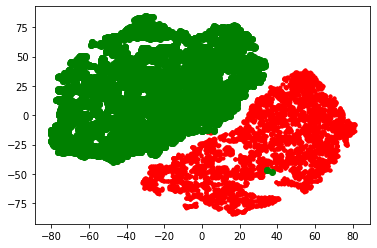

In [25]:
# 降维示意图
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go')
plt.show()

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


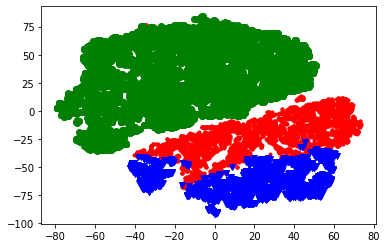

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4411399438299433


In [26]:
# 分为3类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv")
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


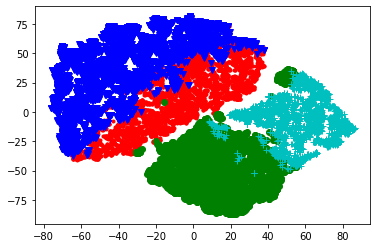

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.2665146707446006


In [27]:
# 分为四类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=4, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv",d4[0],d4[1],"c+")
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


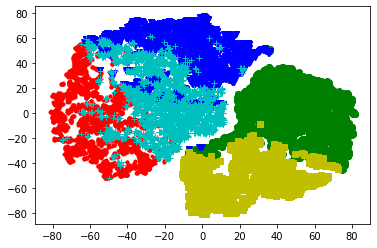

In [28]:
# 分为5类
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE()
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
d5 = liris[kmeans_matrix['labels'] == 4]
plt.plot(d1[0], d1[1], 'r.', d2[0], d2[1], 'go',d3[0],d3[1],"bv",d4[0],d4[1],"c+",d5[0],d5[1],"ys")
plt.show()

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


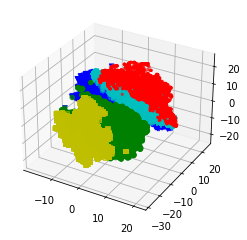

/home/competition/anaconda3/envs/r_env/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.23140896341656925


In [29]:
# 分为5类 3维展示
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = Spot_A_RealTimeData.copy().drop(['地点','监测时间'],axis = 1)
X[X == '—'] = np.NaN
X = X.dropna()
kmeans = KMeans(n_clusters=5, random_state=0).fit(X[['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)']])
labels = kmeans.labels_
labels = pd.DataFrame(labels, columns=['labels'])
kmeans_matrix = X
kmeans_matrix.insert(kmeans_matrix.shape[1],'labels',labels)
tsne = TSNE(n_components=3)
a = tsne.fit_transform(kmeans_matrix)
liris = pd.DataFrame(a, index=kmeans_matrix.index)
d1 = liris[kmeans_matrix['labels'] == 0]
d2 = liris[kmeans_matrix['labels'] == 1]
d3 = liris[kmeans_matrix['labels'] == 2]
d4 = liris[kmeans_matrix['labels'] == 3]
d5 = liris[kmeans_matrix['labels'] == 4]
for d,c,m in [(d1,"r","."),(d2,'g','o'),(d3,'b','v'),(d4,'c','+'),(d5,'y','s')]:
    ax.scatter(d[0],d[1],d[2],c =c,marker = m)
plt.show()
print(metrics.silhouette_score(X, labels, metric='euclidean'))

In [30]:
# 基于k = 5时的kmeans分析
# 先使用随机产生的数据作为AQI进行分析
# Attention:其中的label是气象类别
# 可对其进行回归等分析
X[X['labels']==1].var()/X[X['labels']==1].mean()# 变异系数
X['Fake_AQI'] = np.random.randint(50,300,X.shape[0])


In [31]:
#回归
X_svm = X.drop(['温度(℃)','湿度(%)','气压(MBar)','风速(m/s)','风向(°)','Fake_AQI'],axis = 1)
X_svm['labels'] = LabelEncoder().fit_transform(X_svm['labels'])
y_svm = X['Fake_AQI']
train_X,test_X,train_y,test_y = train_test_split(X_svm,
                                                    y_svm,
                                                    test_size=0.2)

regr = svm.SVR()
regr.fit(train_X, train_y)



SVR()

# 三四部分
第三问题目中要求模型对各地点均适用，因此可以假设在相同的天气和污染情况下，各地的AQI相差不大

目前思路：处理完成数据后，使用xgboost进行拟合,其中只需要表1与表2，易得表3可以通过表二得出

自变量中，若想预测$t$时刻的$Y$，可以将$t$时刻的预测值与$t-1$时刻的观测值纳入

In [47]:
# 时间处理
for i in [Spot_A_FirstPrediction,Spot_B_FirstPrediction,Spot_C_FirstPrediction]:
    i['模型运行日期'] = pd.to_datetime(i['模型运行日期'])
    i['预测时间'] = pd.to_datetime(i['预测时间'])
for j in [Spot_A_RealTimeData,Spot_B_RealTimeData,Spot_C_RealTimeData]:
    j['监测时间'] = pd.to_datetime(j['监测时间'])
for i in [Spot_A_RealTimeData_ByDay,Spot_B_RealTimeData_ByDay,Spot_C_RealTimeData_ByDay]:
    i['监测日期'] = pd.to_datetime(i['监测日期'])


In [99]:
Spot_A_FirstPrediction_temp = Spot_A_FirstPrediction.copy()

Spot_A_FirstPrediction_temp['预测时间'] = Spot_A_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_A_RealTimeData_temp = Spot_A_RealTimeData.copy()
Spot_A_FirstPrediction_temp.drop_duplicates(subset = ['预测时间'],keep = 'last',inplace = True)

Spot_A_Train_Data = Spot_A_RealTimeData_temp.merge(Spot_A_FirstPrediction_temp,how='inner',left_on='监测时间',right_on='预测时间')

Spot_A_RealTimeData_temp = Spot_A_RealTimeData.copy()
Spot_A_RealTimeData_temp['监测时间'] = Spot_A_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_A_Train_Data = Spot_A_Train_Data.merge(Spot_A_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],how='inner',left_on="监测时间",right_on='监测时间')


In [102]:
Spot_B_FirstPrediction_temp = Spot_B_FirstPrediction.copy()
Spot_B_FirstPrediction_temp['预测时间'] = Spot_B_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_B_RealTimeData_temp = Spot_B_RealTimeData.copy()
Spot_B_FirstPrediction_temp.drop_duplicates(subset = ['预测时间'],keep = 'last',inplace = True)
Spot_B_Train_Data = Spot_B_RealTimeData_temp.merge(Spot_B_FirstPrediction_temp,how='inner',left_on='监测时间',right_on='预测时间')
Spot_B_RealTimeData_temp = Spot_B_RealTimeData.copy()
Spot_B_RealTimeData_temp['监测时间'] = Spot_B_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_B_Train_Data = Spot_B_Train_Data.merge(Spot_B_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],how='inner',left_on="监测时间",right_on='监测时间')
Spot_B_Train_Data = Spot_B_Train_Data.drop_duplicates()
Spot_B_Train_Data.shape


(8509, 43)

In [103]:
Spot_C_FirstPrediction_temp = Spot_C_FirstPrediction.copy()
Spot_C_FirstPrediction_temp['预测时间'] = Spot_C_FirstPrediction_temp["预测时间"] - timedelta(hours=1)
Spot_C_RealTimeData_temp = Spot_C_RealTimeData.copy()
Spot_C_FirstPrediction_temp.drop_duplicates(subset = ['预测时间'],keep = 'last',inplace = True)
Spot_C_Train_Data = Spot_C_RealTimeData_temp.merge(Spot_C_FirstPrediction_temp,how='inner',left_on='监测时间',right_on='预测时间')
Spot_C_RealTimeData_temp = Spot_C_RealTimeData.copy()
Spot_C_RealTimeData_temp['监测时间'] = Spot_C_RealTimeData_temp["监测时间"] - timedelta(hours=1)
Spot_C_Train_Data = Spot_C_Train_Data.merge(Spot_C_RealTimeData_temp[['监测时间',
                                                                        'SO2监测浓度(μg/m³)',
                                                                        'NO2监测浓度(μg/m³)',
                                                                        'PM10监测浓度(μg/m³)',
                                                                        'PM2.5监测浓度(μg/m³)',
                                                                        'O3监测浓度(μg/m³)',
                                                                        'CO监测浓度(mg/m³)']],how='inner',left_on="监测时间",right_on='监测时间')
Spot_C_Train_Data.shape

(8484, 43)

In [ ]:
# 本函数用来修正数据，使其满足题目预测时间限制要求，即所采用的最新实测数据为7时

def Data_Rect(df):
    df_temp = df.copy()
    df_latest_data = df[df['监测时间'].dt.hour]
    for index, row in df_temp.iterrows():
        df['监测时间']



In [36]:
Spot_Data = pd.concat([Spot_C_Train_Data,
                            Spot_C_Train_Data,
                            Spot_C_Train_Data])

In [37]:
Spot_Data.isna().sum()


监测时间                    0
地点_x                    0
SO2监测浓度(μg/m³)_x        0
NO2监测浓度(μg/m³)_x        0
PM10监测浓度(μg/m³)_x     105
PM2.5监测浓度(μg/m³)_x     60
O3监测浓度(μg/m³)_x         0
CO监测浓度(mg/m³)_x         0
温度(℃)                   0
湿度(%)                   0
大气压(mBar)               0
风速(m/s)                 9
风向(°)                   0
模型运行日期                  0
预测时间                    0
地点_y                    0
近地2米温度（℃）               0
地表温度（K）                 0
比湿（kg/kg）               0
湿度（%）                   0
近地10米风速（m/s）            0
近地10米风向（°）              0
雨量（mm）                  0
云量                      0
边界层高度（m）                0
大气压（Kpa）                0
感热通量（W/m²）              0
潜热通量（W/m²）              0
长波辐射（W/m²）              0
短波辐射（W/m²）              0
地面太阳能辐射（W/m²）           0
SO2小时平均浓度(μg/m³)        0
NO2小时平均浓度(μg/m³)        0
PM10小时平均浓度(μg/m³)       0
PM2.5小时平均浓度(μg/m³)      0
O3小时平均浓度(μg/m³)         0
CO小时平均浓度(mg/m³)         0
SO2监测浓度(μg/m³)_y        0
NO2监测浓度(μg/m

In [38]:
# 插值解决缺失值问题
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(Spot_Data[1:,])

TypeError: '(slice(1, None, None),)' is an invalid key